## 🕵️ **Anomaly Detection**
-------

### 🌳**Isolation Forest**
- 하나의 객체를 고립시키는 tree를 생성하자는 아이디어 이용
- 정상 데이터를 고립시키는 분기(split)수 > 이상치 데이터를 고립시키는 분기(split)수 임을 이용
- **정상 데이터** : tree의 말단 노드에 가까운 depth를 가짐
- **이상치 데이터** : root 노드에 가까운 depth를 가짐
- **outlier score** : 특정 한 개체가 isolation 되는 leaf 노드 (terminal 노드)까지의 거리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn import model_selection
import os
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_blobs,load_digits

### 🌳 **Isolation Forest의 전체적인 과정**
------
#### **iTree**
1. Sub-sampling : 비복원 추출로 데이터 중 일부 샘플링
2. 변수선택 : 데이터 x의 변수 중 q개를 임의로 선택
3. split point 설정 : 변수 q의 범위(min~max) 중 uniform하게 split point를 선택
4. 1~3번의 과정을 모든 관측치가 split되거나 임의의 split 횟수에 도달할 때까지 반복, 경로 길이를 모두 저장
#### **Isolation Forest**
5. 1~4의 과정(iTree)을 여러번 반복

### 📂 **일반적인 데이터셋**
------
- make_blobs 함수를 이용하여 임의의 데이터셋을 생성하고 isolation forest를 이용하여 이상치 탐지를 진행해봅니다.

#### **Step 1: 데이터셋 생성**
* scikit-learn의 make_blobs 함수를 이용하여 가상 데이터 생성
* make_blobs 함수
    * n_samples : 표본 데이터의 수
    * n_features : 독립 변수의 수
    * centers : 생성할 클러스터의 수
    * cluster_std : 클러스터의 표준편차

In [2]:
X, y = make_blobs(n_samples = 300, centers = 1, cluster_std = 1.5, random_state = 42)

- 생성된 데이터셋을 시각화해보자면 다음과 같습니다.

Text(0.5, 1.0, 'Data for Isolation Forest')

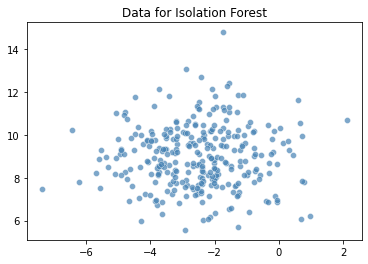

In [3]:
# 데이터셋 시각화
sns.scatterplot(X[:,0], X[:,1], alpha = 0.7, color = 'steelblue')
plt.title("Data for Isolation Forest", size = 12)

#### **Step 2 : Model fit**
* 다음으로 데이터셋을 model에 fit 시켜줍니다
    - Isolation Forest의 세팅은 scikit-learn에 있는 기본 세팅으로 진행합니다
    - n_estimators = 10
    - contamination = 'auto'

In [4]:
# model fit하기
iforest = IsolationForest(n_estimators = 100, contamination = 'auto', max_features = 1.0, random_state = 42 )

#### **Step 3 : 이상치 예측**
* X를 model에 대입하여 이상치 탐지를 진행합니다.
* predict 함수를 이용하면 각 X의 sample들에 대해 -1 또는 1의 값을 반환하게 되며,
    각각은 **-1 : 이상치, 1: 정상**을 의미하고 있습니다.

⛔ **주의사항** : **score_samples** 함수는 anomaly score의 역수로 산출되기 때문에 -1의 값을 곱해줘야 높은 score값은 이상치, 낮은 score값은 정상이라고 할 수 있습니다.

In [5]:
# fit한 모델에 X값을 넣어 예측
iforest = iforest.fit(X)
pred = iforest.predict(X)
scores = -1*iforest.score_samples(X)

In [6]:
# -1은 이상치, 1은 정상을 의미
np.unique(pred)

array([-1,  1])

#### 📊 **결과 시각화**

Text(0.5, 1.0, 'Data for Isolation Forest')

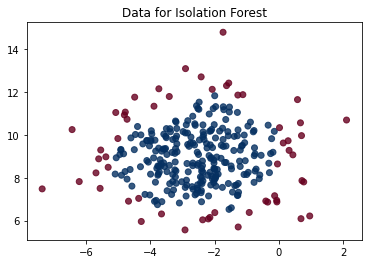

In [7]:
# 예측 결과 시각화
plt.scatter(X[:,0], X[:,1], c = pred, alpha = 0.8, cmap = 'RdBu')
plt.title('Data for Isolation Forest', size = 12)

위와 같이 정상(1)로 예측되는 경우 파란색으로, 이상치(-1)로 예측되는 경우는 빨간색으로 시각화합니다. cluster의 중심에 가까운 점들의 경우 정상으로 표시되고, cluster에서 벗어난 점들의 경우 이상치로 표시되는 것을 확인할 수 있습니다. Isolation Forest의 개념 자체와 연관시켜 생각해보면, cluster의 중심에 있는 점들의 경우에는 고립시키는데 많은 수의 분기(split)가 필요하기 때문에 정상으로 탐지하고, cluster의 외부에 있는 점들의 경우는 고립시키는데 비교적 적은 수의 분기(split)가 필요하기 때문에 이상치라고 할 수 있습니다. 

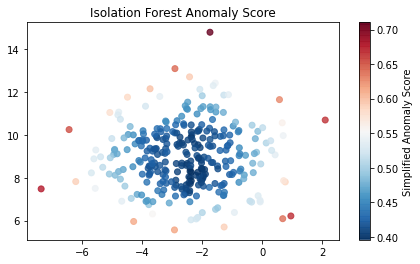

In [8]:
# anomaly score의 시각화
plt.figure(figsize = (7,4))
plt.title('Isolation Forest Anomaly Score', size = 12)
plt.scatter(X[:,0], X[:,1], c = scores, alpha = 0.8, cmap = 'RdBu_r')
plt.colorbar(label = 'Simplified Anomaly Score')
plt.show()

이번에는 anomaly score 값들을 시각화 해보도록 하겠습니다. score값이 높으면 빨간색으로, score값이 낮으면 파란색으로 표기되게 하였습니다. 즉, score값이 높을수록 이상치에 가깝다고 볼 수 있습니다. 위의 결과에서 정상이라고 판단되는 경우 (파란색 부분) 이라고 할 수 있으며, 이상치로 판단되는 경우 (빨간색 부분) 이라고 할 수 있습니다. cluster의 중심에 가까울수록 anomaly score의 값이 낮고, 중심에서 멀리 떨어져 있을수록 일반적으로 anomaly score값이 크다는 점을 알 수 있습니다. 추가적으로 위의 일반적인 데이터 분포 그림과 비교하여 보았을 때, 약 0.5 정도의 값을 기준으로 하여 정상과 이상치가 나뉘고 있음을 확인할 수 있습니다.

Text(0.5, 1.0, 'Isolation forest Result : Example')

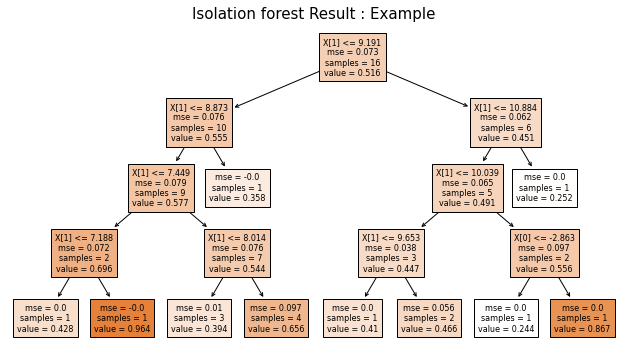

In [9]:
from sklearn.tree import plot_tree
iso = IsolationForest(n_estimators = 100, contamination = 'auto', max_features = 1.0, random_state = 42, max_samples = 16)

iso = iso.fit(X)
pred = iso.predict(X)
scores = -1*iso.score_samples(X)

result = {-1: 'anomaly', 1 : 'normal'}

model = iso.estimators_[0]
plt.figure(figsize=(11, 6)) 
plot_tree(model, filled = True, fontsize = 8, class_names = result)
plt.title('Isolation forest Result : Example', fontsize = 15)

In [10]:
max_depth = int(np.ceil(np.log2(max(iso.max_samples, 2))))
print('max_depth: ', max_depth)

max_depth:  4


한가지 예시를 시각화 해보자면 다음과 같습니다. 위의 경우 Isolation Forest에서 max_samples 수(n)를 16으로 설정하였고, tree의 depth는 $log_2{n}$ 이기 때문에 4임을 확인할 수 있습니다. 각각의 node에서 어떤 값을 기준으로 분기가 되는지 살펴볼 수 있습니다. 예를 들어 root node에서는 X[1]의 값이 9.191보다 큰지 작은지를 기준으로 나누고 있으며, 각 노드에서의 mse값을 표기하고 있습니다.

### 📂 **tabular 데이터셋**
------
- **Synthetic Financial Datasets For Fraud Detection** [download](https://www.kaggle.com/datasets/ealaxi/paysim1)
- 이번에는 일반적인 tabular 데이터셋을 이용하여 isolation forest를 적용해봅니다.

#### **Step 1: 데이터셋 불러오기**
* 데이터셋을 불러와 train, test로 나누어 줍니다.

In [11]:
# 데이터셋 불러오기
paysim = pd.read_csv('./dataset/paysim.csv')
paysim

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


- 총 8개의 연속형 변수, 3개의 categorical 변수로 이루어져 있음을 확인할 수 있습니다.

In [12]:
# 데이터셋에 대한 요약 확인
paysim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [13]:
# 데이터셋 결측치 관측
paysim.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

- 데이터 용량 크기의 한계상 약 10%(630000)의 데이터만을 추출합니다.

In [14]:
paysim_samp = paysim.sample(n = 630000, random_state = 42)
paysim_samp = paysim_samp.reset_index(drop = True)
paysim_samp

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
1,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
2,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
3,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0
4,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0
...,...,...,...,...,...,...,...,...,...,...,...
629995,140,CASH_OUT,73993.89,C1098622650,35704.00,0.00,C394372500,53368.66,216525.54,0,0
629996,229,CASH_IN,83729.72,C51418095,505192.00,588921.72,C87723454,0.00,0.00,0,0
629997,351,CASH_IN,94388.76,C903949852,169427.00,263815.76,C994927231,0.00,0.00,0,0
629998,136,CASH_IN,251509.61,C1988080501,750.00,252259.61,C1311828205,719194.04,467684.43,0,0


- isFraud = 1, 즉, 이상치에 해당되는 데이터의 index만을 추출합니다. 다음과 같은 과정을 진행하는 이유는 정상데이터만을 가지고 학습하기 위함입니다. 정상데이터를 추출하기 위해 우선 이상치 데이터에 대한 index를 추출한 후, 전체 index에서 이상치 데이터의 index를 빼서 정상 데이터의 index를 구해줍니다.

In [15]:
test_index = []

for i in range(len(paysim_samp)):
    if paysim_samp['isFraud'][i] == 1:
        test_index.append(paysim_samp.index[i])

In [16]:
test_index[:5]

[283, 420, 548, 952, 1816]

In [17]:
all_index = list(paysim_samp.index)
train_index = [x for x in all_index if x not in test_index]

- 다음과 같이 전체 630000개의 데이터셋 중에서 62190개의 정상 데이터와 810개의 이상치 데이터가 있음을 확인할 수 있습니다.

In [18]:
print(len(all_index), len(train_index), len(test_index))

630000 629190 810


- 앞서 구한 index를 바탕으로 정상 데이터만을 임시 train 데이터셋으로, 이상치 데이터를 임시 test 데이터셋으로 나누어 줍니다.

In [19]:
train_temp = paysim_samp.loc[train_index]
test_temp = paysim_samp.loc[test_index]

- 일부 정상 데이터를 추출하여 test 데이터셋에 합쳐줍니다. 이는 test 데이터셋에 정상과 이상치 데이터가 포함되게 하기 위함입니다.

In [20]:
test_add = train_temp.sample(n = 6200, random_state = 42)
test_add_index = list(test_add.index)
all_train_index = list(train_temp.index)
train_remain_index = [x for x in all_train_index if x not in test_add_index]

test_add_temp = train_temp.loc[test_add_index]

test = pd.concat([test_temp, test_add_temp], axis = 0)
test = test.reset_index(drop = True)
train = train_temp.loc[train_remain_index]
train = train.reset_index(drop = True)

In [21]:
# categorical 변수는 drop해줌
X_train = train.drop(['type', 'nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud'], axis = 1)
y_train = train['isFraud']

X_test = test.drop(['type', 'nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud'], axis = 1)
y_test = test['isFraud']

#### **Step 2: Model fit**
* 다음으로 데이터셋을 model에 fit 시켜줍니다
    - Isolation Forest의 세팅은 앞선 방법과 마찬가지로 scikit-learn에 있는 기본 세팅으로 진행합니다
    - n_estimators = 10
    - contamination = 'auto'

In [22]:
# model fitting 진행
model = IsolationForest(n_estimators = 50, max_samples = 'auto', contamination = 0.5, max_features = 1.0)
model.fit(X_train)

IsolationForest(contamination=0.5, n_estimators=50)

#### **Step 3 : 이상치 예측**
* X test 데이터셋를 model에 대입하여 이상치를 예측합니다.
* predict 함수를 이용하면 각 X test 데이터셋의 sample들에 대해 -1 또는 1의 값을 반환하게 되며,
    각각은 **-1 : 이상치, 1 : 정상**을 의미하고 있습니다.

In [23]:
# y값 예측
y_pred = model.predict(X_test)
scores = -1*model.score_samples(X_test)

# id = list(X_test.index)
result = pd.DataFrame()
# isolation forest의 output은 -1(이상치), 1(정상)으로 나오지만
# 원래 y_test값에서는 이상치이면 1, 정상이면 0의 값을 가지지만 때문에 형태를 바꾸어줌
result['real_anomaly'] = y_test
result['pred'] = y_pred
result['pred'] = result['pred'].replace({1:0})
result['pred'] = result['pred'].replace({-1:1})
result['score'] = list(scores)

result

,real_anomaly,pred,score
0,1,1,0.441777
1,1,1,0.457075
2,1,1,0.639353
3,1,1,0.505465
4,1,1,0.479968
...,...,...,...
7005,0,1,0.455150
7006,0,0,0.329469
7007,0,0,0.328856
7008,0,1,0.365579


In [24]:
index = list(result.index)
len(index)

7010

- anomaly score가 특정 threshold를 넘어가는 경우 이상치라고 판별하므로, 이상치로 예측된 값들 중 anomaly score가 가장 낮은 값을 threshold라고 할 수 있습니다.

In [25]:
threshold = min(result[result['pred']== 1]['score'])
print('threshold', threshold)

threshold 0.3595333342234266


### 📊 **Result**

In [26]:
def plot_score(df, threshold, index, score, real, root_path, title):
    figure, ax = plt.subplots(nrows = 3, figsize=(18, 12))
    # ex: title = 'LOF'
    figure.suptitle(title, fontsize = 20)

    s0 = sns.lineplot(x = df[index][:2500], y = df[score][:2500], alpha = 0.7, ax = ax[0])
    sns.lineplot(x = df[index][:2500], y = df[real][:2500], alpha = 0.3, color = 'blue', ax = ax[0])
    s0.axhline(threshold, color = 'r', linestyle = 'solid')
    ax[0].set_xticks(np.arange(0,2500,100))
    ax[0].tick_params(labelsize = 12) 
    ax[0].set_ylabel('score', fontsize = 14)

    s1 = sns.lineplot(x = df[index][2500:5000], y = df[score][2500:5000], alpha = 0.7, ax = ax[1])
    s1.axhline(threshold, color = 'r', linestyle = 'solid')
    sns.lineplot(x = df[index][2500:5000], y = df[real][2500:5000], alpha = 0.3, color = 'blue', ax = ax[1])
    ax[1].set_xticks(np.arange(2500,5000,100))
    ax[1].tick_params(labelsize = 12) 
    ax[1].set_ylabel('score', fontsize = 14)
    ax[1].set_xlabel('index', fontsize = 14)

    s2 = sns.lineplot(x = df[index][5000:7010], y = df[score][5000:7010], alpha = 0.7, ax = ax[2])
    s2.axhline(threshold, color = 'r', linestyle = 'solid')
    sns.lineplot(x = df[index][5000:7010], y = df[real][5000:7010], alpha = 0.3, color = 'blue', ax = ax[2])
    ax[2].set_xticks(np.arange(5000,7010,100))
    ax[2].tick_params(labelsize = 12) 
    ax[2].set_ylabel('score', fontsize = 14)
    ax[2].set_xlabel('index', fontsize = 14)

    name = title  + '.png'
    save_name = os.path.join(root_path, name)
       
    plt.savefig(save_name, bbox_inches='tight',pad_inches = 0)

def get_metrics(y_test, y_pred):
    f1 = f1_score(y_test, y_pred)
    print('f1 score :', round(f1,3))
    roc_auc = roc_auc_score(y_test, y_pred) 
    print("ROC AUC Score: {}".format(round(roc_auc, 3)))
    recall = recall_score(y_test, y_pred) 
    print("recall: {}".format(round(recall, 3)))
    precision = precision_score(y_test, y_pred) 
    print("precision: {}".format(round(precision, 3)))
    return f1, roc_auc, recall, precision

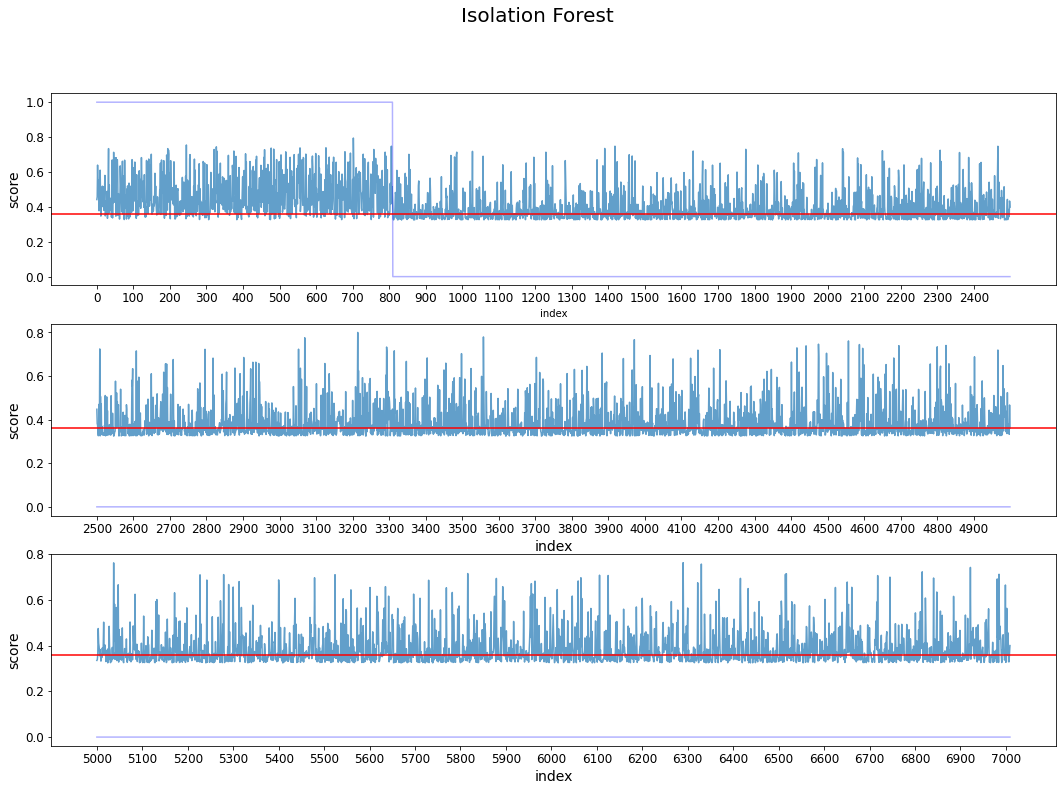

In [27]:
result['index'] = range(0, len(result))
root_path = './result/'
title = 'Isolation Forest'
plot_score(result, threshold, 'index', 'score', 'real_anomaly', root_path, title)

다음과 같이 앞 영역의 경우 이상치를 잘 탐지하고 있으나 뒷부분의 경우에는 잘 탐지하지 못하고 있는 모습을 확인할 수 있었습니다.

In [28]:
get_metrics(y_test, result['pred'])

f1 score : 0.302
ROC AUC Score: 0.678
recall: 0.848
precision: 0.183


(0.30171277997364954,
 0.677541816009558,
 0.8481481481481481,
 0.18349358974358973)

#### Result using metrics

|F1-score|Auroc|Recall|Precision
|:--:|:--:|:--:|:--:|
|0.300|0.675|0.842|0.183|

다음과 같이 f1-score는 약 0.300, auroc는 약 0.675, recall은 약 0.842, precision은 약 0.183으로 나온 것을 확인할 수 있습니다. recall 즉, 실제로 anomaly 중 anomaly로 잘 맞추는 경우는 많았으나 precision이 매우 낮아 결론적으로 낮은 f1-score가 산출되었음을 확인할 수 있었습니다.

### 📊 **Result**

In [29]:
get_metrics(y_test, result['pred'])

f1 score : 0.302
ROC AUC Score: 0.678
recall: 0.848
precision: 0.183


(0.30171277997364954,
 0.677541816009558,
 0.8481481481481481,
 0.18349358974358973)

|Accuracy|Recall|Precision|F1-score|
|:--:|:--:|:--:|:--:|
|98|78|62|55|

### 🌲 **Isolation Forest의 특징**
- **sub-sampling** : sampling한 데이터로 모델을 구성함
- **swamping** : 정상과 이상치 데이터가 가까이 위치하게 되는 경우 잘못 분류를 하게 됨
- **masking** : 이상치가 군집화 되어 있어 정상으로 잘못 분류하게 됨
- **high dimensional data** : 고차원의 데이터에서는 잘 동작하지 않을 수 있음

#### **Digit 데이터셋**을 이용함

In [30]:
digits = load_digits()

X_digits, Y_digits = digits.data, digits.target

print("Dataset Size : ", X_digits.shape, Y_digits.shape)

Dataset Size :  (1797, 64) (1797,)


In [31]:
X_digits

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [32]:
iforest = IsolationForest(n_estimators=300, contamination=0.05)
iforest.fit(X_digits)

IsolationForest(contamination=0.05, n_estimators=300)

In [33]:
preds = iforest.predict(X_digits)
preds[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [34]:
X_outliers = X_digits[preds == -1]
X_valid = X_digits[preds != -1]

print("Original Samples : ",X_digits.shape[0])
print("Number of Outliers : ", X_outliers.shape[0])
print("Number of Normal Samples : ", X_valid.shape[0])

Original Samples :  1797
Number of Outliers :  90
Number of Normal Samples :  1707


In [35]:
def plot_few_outliers(X_outliers):
    outliers = []
    for x in X_outliers[:10]:
        outliers.append(x.reshape(8,8))

    fig = plt.figure(figsize=(10,4))
    plt.imshow(np.hstack(outliers), cmap="Blues");

def plot_few_valid_samples(X_valid):
    valid_samples = []
    for x in X_valid[:10]:
        valid_samples.append(x.reshape(8,8))

    fig = plt.figure(figsize=(10,4))
    plt.imshow(np.hstack(valid_samples), cmap="Blues");

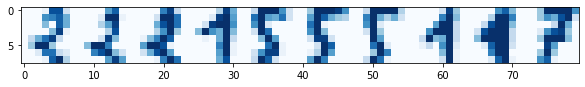

In [36]:
plot_few_outliers(X_outliers)

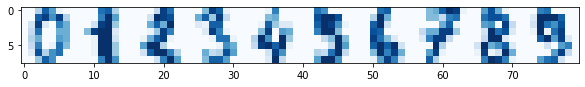

In [37]:
plot_few_valid_samples(X_valid)

* **References**
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest 
    - https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py